# Classificació de l'idioma d'una paraula
Autors:
- Jonathan Salisbury Vega
- Julià Wallis Medina

Aquesta pràctica consisteix en la classificació de l'idioma d'una paraula emprant SVMs. Per a això, s'ha creat un dataset de paraules en diferents idiomes, i s'han extret diferentes característiques de les paraules. Després s'ha entrenat un model de classificació per tal de poder classificar les paraules en els seus idiomes corresponents.

In [70]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import top_k_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
# Preprocessing

In [72]:
# Read Data and convert to lowercase
df = pd.read_csv('data/data3.csv', sep=',')
df = df.apply(lambda x: x.astype(str).str.lower())

In [73]:
df.head()

,angles,catala,espanyol,alemany,frances,polones,portugues,rus,italia,suec
0,as,com,como,wie,comme,jak,como,в качестве,come,som
1,his,seva,su,seine,le sien,jego,seu,его,il suo,hans
2,that,que,que,das,ce,że,este,что,quello,den där
3,he,ell,él,er,il,on,ele,он,lui,han
4,was,era,estaba,war,a été,był,foi,был,era,var


In [74]:
# concat all languages into one Dataframe
dfs = list()
for lang in df.columns:
    df_lang = pd.DataFrame(df[lang])
    df_lang['lang'] = lang[:3]
    df_lang = df_lang.rename(columns={lang: 'word'})
    dfs.append(df_lang)
df2 = pd.concat(dfs, ignore_index=True)

In [75]:
df2.head()

,word,lang
0,as,ang
1,his,ang
2,that,ang
3,he,ang
4,was,ang


# Feature Engineering

In [76]:
def count_special_characters(word: str, string: str) -> int:
    num_special_characters=0
    for char in word:
        if char in string:
            num_special_characters+=1
    return num_special_characters

In [77]:
def has_suffix(word: str, suffixes: list) -> int:
    num_suffixes=0
    for suffix in suffixes:
        if word.endswith(suffix):
            num_suffixes+=1
    return num_suffixes

In [78]:
def has_prefix(word: str, prefixes: list) -> int:
    num_prefixes=0
    for prefix in prefixes:
        if word.startswith(prefix):
            num_prefixes+=1
    return num_prefixes

In [79]:
def has_group(word: str, groups: list) -> int:
    num_groups=0
    for group in groups:
        if group in word:
            num_groups+=1
    return num_groups

In [92]:
def diptongos():
    list=[]
    vowels = "aeiouàèìòùáéíóúäëïöüâêîôû"
    # append all possible combinations of vowels
    for i in vowels:
        for j in vowels:
            list.append(i+j)
    return list

In [94]:
# Length
df2['len'] = df2['word'].str.len()

dict = {
        'vow':'aeiou', 
        'acc':'àèìòùáéíóú', 
        'accl':'àèìòù', 
        'accr':'áéíóú', 
        'die':'äëïöü',
        'cir':'âêîôû', 
        'ñ':'ñ', 
        'ç':'ç', 
        'ale': 'ß', 
        'rus': 'бвгджзийклмнпрстфцчшщъыьэюя',
        'pol': 'ąćęłńóśźż', 
        'por': 'ãõ', 
        'sue': 'åäö',
        'esp': 'áéíóúü',
        'ita': 'àèéìíîòóùú',
        'fra': 'àâæçéèêëîïôœùûüÿ',
        'ger': 'äöüß',
        'cat': 'àèéíïòóúüç',
        'num_words': ' ',
        "apos": "'",
        "hyph": "-",
        "rares": "kqwxyz"}

vowel_pairs = diptongos()
groups = {
        "pairs_eng": ["sh", "th", "ch", "ck", "ph", "ng", "qu", "tr", "st", "wh", "tr"],
        "pairs_cat": ["ny", "tx", "sc", "nc", "rc", "ll", "nc", "pc", "pr", "br", "fr", "ts", "ix",  "nd", "pr", "bl"],
        "pairs_esp": ["nd", "nt", "ch", "rr", "ll", "qu", "gu", "nc", "mb", "pr"],
        "pairs_ger": ["tch", "ck", "ng", "qu", "tz", "ss", "st", "sp", "str", "sch"],
        "pairs_por": ["tch", "lh", "nh", "qu", "sc", "rr", "nc", "gu", "lm", "rm"],
        "pairs_pol": ["ch", "dz", "d±", "di", "rz", "sz", " Sc", "Ed", "id"],
        "pairs_it": ["ch", "gl", "gn", "sc", "qu", "scl", "ch", "ci", "gli", "gn", "io", "la", "leu", "Ii", "Io", "ne"],
        "pairs_swe": ["ch", "ck", "cid", "dt", "gg", "ll", "ng", "sk", "st", "tt"],
        "pairs_fre": ["ch", "che", "eau", "ent", "es", "ette", "eur", "iau", "ie", "in"],
        "diptongos": vowel_pairs
        }



prefix = {
        'pre_eng': ["anti", "be", "de", "dis", "en", "ex", "im", "in", "non", "pre", "re", "un"],
        'pre_esp': ["anti", "auto", "contra", "des", "en", "ex", "in", "inter", "pre", "re", "sub", "trans"],
        'pre_cat': ["anti", "ab", "avant", "arxi", "dia", "hemi", "auto", "contra", "des", "en", "ex", "in", "inter", "pre", "re", "sub", "trans"],
        'pre_ita': ["auto", "dis", "en", "ex", "im", "in", "ir", "mal", "per", "pre", "pro", "re", "sott", "sotto", "tran", "ab"],
        'pre_fra': ["anti", "auto", "co", "con", "contre", "de", "des", "en", "ex", "in", "inter", "mal", "pre", "pro", "re", "sub", "sur"],
        'pre_por': ["auto", "co", "contra", "des", "em", "en", "ex", "in", "inter", "pre", "pro", "re", "sub"],
        'pre_ale': ["be", "ein", "ent", "er", "ge", "hin", "ver", "zer"],
        'pre_sue': ["be", "för", "in", "om", "över", "under"],
        'pre_pol': ["przed", "nad", "na", "pod", "z", "w"]
}

suffix = {
        'suf_eng': ["able", "al", "ation", "er", "est", "ful", "ing", "ion", "ive", "less", "ly", "ness", "ous", "s", "y"],
        'suf_esp': ["ado", "ador", "aje", "anza", "ar", "ario", "ero", "iente", "illa", "ina", "izar", "oso", "ón", "udo", "er", "ir"],
        'suf_cat': ["ana", "aca", "ada", "al", "am", "ador", "tge", "isme", "nça", "ar", "ista", "istic", "mente", "ment", "ina", "tzar", "nça" "on", "um", "ut", "uda", "er", "ir", "re"],
        'suf_ita': ["abile", "are", "ario", "atore", "azione", "ente", "evole", "ificare", "ivo", "izzare", "ore", "orente", "orevole", "oso", "ura"],
        'suf_fra': ["age", "aille", "ance", "eau", "eux", "eur", "eur(e)se", "ie", "iment", "ion", "ique", "isme", "iste", "ition", "ive", "oire", "ure", "y"],
        'suf_por': ["al", "ão", "ar", "ês", "ência", "eza", "ia", "ício", "imento", "ir", "or", "oso", "ura"],
        'suf_ale': ["bar", "e", "ei", "er", "heit", "ich", "ig", "in", "keit", "lich", "ling", "sam", "schaft", "ung"],
        'suf_sue': ["ande", "are", "bar", "dom", "else", "en", "eri", "het", "ing", "isk", "itet", "lig", "lighet", "ning", "ningen", "ningar", "ningen"],
        'suf_pol': ["acja", "ać", "anie", "eć", "enie", "enie", "enie", "enie", "enie", "enie", "enie", "enie", "enie", "enie", "enie", "enie"]
}

for column in dict:
        df2[column] = df2['word'].apply(lambda row: count_special_characters(row, dict[column]))

for column in groups:
        df2[column] = df2['word'].apply(lambda row: has_group(row, groups[column]))

for column in prefix:
        df2[column] = df2['word'].apply(lambda row: has_prefix(row, prefix[column]))

for column in suffix:
        df2[column] = df2['word'].apply(lambda row: has_suffix(row, suffix[column]))



In [96]:
df2.head()

,word,lang,len,vow,acc,accl,accr,die,cir,ñ,...,suf_eng,suf_esp,suf_cat,suf_ita,suf_fra,suf_por,suf_ale,suf_sue,suf_pol,diptongos
0,as,1,2,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,his,1,3,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,that,1,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,he,1,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,was,1,3,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [97]:
df2['lang']=df2['lang'].astype('category').cat.codes
df2.corr().round(2)['lang']

C:\Users\walli\AppData\Local\Temp\ipykernel_15884\756038714.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2.corr().round(2)['lang']


lang         1.00
len          0.06
vow         -0.24
acc         -0.04
accl        -0.05
accr        -0.02
die          0.12
cir          0.01
ñ           -0.02
ç            0.03
ale         -0.06
rus          0.37
pol          0.09
por          0.06
sue          0.22
esp         -0.05
ita         -0.04
fra         -0.06
ger          0.11
cat         -0.06
num_words    0.06
apos        -0.00
hyph         0.04
rares        0.04
pairs_eng   -0.10
pairs_cat   -0.07
pairs_esp   -0.14
pairs_ger   -0.08
pairs_por   -0.06
pairs_pol   -0.08
pairs_it    -0.15
pairs_swe   -0.09
pairs_fre   -0.15
pre_eng     -0.06
pre_esp     -0.05
pre_cat     -0.05
pre_ita     -0.05
pre_fra     -0.06
pre_por     -0.06
pre_ale     -0.12
pre_sue     -0.01
pre_pol     -0.06
suf_eng     -0.10
suf_esp     -0.08
suf_cat     -0.10
suf_ita      0.01
suf_fra     -0.06
suf_por     -0.03
suf_ale     -0.15
suf_sue     -0.12
suf_pol      0.03
diptongos   -0.17
Name: lang, dtype: float64

In [98]:
X = df2.drop(['word', 'lang'], axis=1).values
y = df2['lang'].values

# Use PCA to reduce the dimensionality of the data
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)

# Split the data into training, testing and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2)

# Define the SVM model
model1 = svm.SVC(kernel='linear', probability=True)  # linear kernel
model2 = svm.SVC(kernel='poly', degree=3, probability=True)  # polynomial kernel with degree 3
model3 = svm.SVC(kernel='rbf', gamma=0.1, probability=True)  # RBF kernel with gamma = 0.1

model1_pca = svm.SVC(kernel='linear', probability=True)  # linear kernel
model2_pca = svm.SVC(kernel='poly', degree=3, probability=True)  # polynomial kernel with degree 3
model3_pca = svm.SVC(kernel='rbf', gamma=0.1, probability=True)  # RBF kernel with gamma = 0.1


In [99]:
# Train the models on the training data
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

model1_pca.fit(X_train_pca, y_train_pca)
model2_pca.fit(X_train_pca, y_train_pca)
model3_pca.fit(X_train_pca, y_train_pca)

SVC(gamma=0.1, probability=True)

In [100]:
# Evaluate the models on the test data
score1 = model1.score(X_test, y_test)
score2 = model2.score(X_test, y_test)
score3 = model3.score(X_test, y_test)
print(f'Model 1 accuracy: {score1 * 100}%')
print(f'Model 2 accuracy: {score2 * 100}%')
print(f'Model 3 accuracy: {score3 * 100}%\n')

# Evaluate the models on the test data
score1_pca = model1_pca.score(X_test_pca, y_test_pca)
score2_pca = model2_pca.score(X_test_pca, y_test_pca)
score3_pca = model3_pca.score(X_test_pca, y_test_pca)
print(f'Model 1 pca accuracy: {score1_pca * 100}%')
print(f'Model 2 pca accuracy: {score2_pca * 100}%')
print(f'Model 3 pca accuracy: {score3_pca * 100}%')

Model 1 accuracy: 48.532388663967616%
Model 2 accuracy: 45.29352226720648%
Model 3 accuracy: 49.34210526315789%

Model 1 pca accuracy: 47.01417004048583%
Model 2 pca accuracy: 41.85222672064777%
Model 3 pca accuracy: 47.41902834008097%


In [101]:
# Use the trained models to make predictions
predictions1 = model1.predict_proba(X_test)
predictions2 = model2.predict_proba(X_test)
predictions3 = model3.predict_proba(X_test)

predictions1_pca = model1_pca.predict_proba(X_test_pca)
predictions2_pca = model2_pca.predict_proba(X_test_pca)
predictions3_pca = model3_pca.predict_proba(X_test_pca)

In [102]:
print('Top 3 accuracy model 1 %f' % top_k_accuracy_score(y_test, predictions1, k=3))
print('Top 3 accuracy model 2 %f' % top_k_accuracy_score(y_test, predictions2, k=3))
print('Top 3 accuracy model 3 %f\n' % top_k_accuracy_score(y_test, predictions3, k=3))

print('accuracy model 1 pca %f' % top_k_accuracy_score(y_test_pca, predictions1_pca, k=3))
print('Top 3 accuracy model 2 pca %f' % top_k_accuracy_score(y_test_pca, predictions2_pca, k=3))
print('Top 3 accuracy model 3 pca %f' % top_k_accuracy_score(y_test_pca, predictions3_pca, k=3))



Top 3 accuracy model 1 0.796053
Top 3 accuracy model 2 0.772773
Top 3 accuracy model 3 0.795547

accuracy model 1 pca 0.770749
Top 3 accuracy model 2 pca 0.722166
Top 3 accuracy model 3 pca 0.769737


In [103]:
# Generate classification reports for the models
print(classification_report(y_test, model1.predict(X_test), zero_division=0))
print(classification_report(y_test, model2.predict(X_test), zero_division=0))
print(classification_report(y_test, model3.predict(X_test), zero_division=0))

print(classification_report(y_test_pca, model1_pca.predict(X_test_pca), zero_division=0))
print(classification_report(y_test_pca, model2_pca.predict(X_test_pca), zero_division=0))
print(classification_report(y_test_pca, model3_pca.predict(X_test_pca), zero_division=0))


              precision    recall  f1-score   support

           0       0.62      0.51      0.56       201
           1       0.29      0.41      0.34       187
           2       0.31      0.23      0.27       236
           3       0.31      0.28      0.29       181
           4       0.46      0.48      0.47       192
           5       0.41      0.57      0.47       207
           6       0.81      0.68      0.74       191
           7       0.35      0.17      0.23       207
           8       1.00      1.00      1.00       197
           9       0.40      0.59      0.48       177

    accuracy                           0.49      1976
   macro avg       0.50      0.49      0.48      1976
weighted avg       0.49      0.49      0.48      1976

              precision    recall  f1-score   support

           0       0.71      0.39      0.50       201
           1       0.20      0.75      0.31       187
           2       0.32      0.22      0.26       236
           3       0.32 

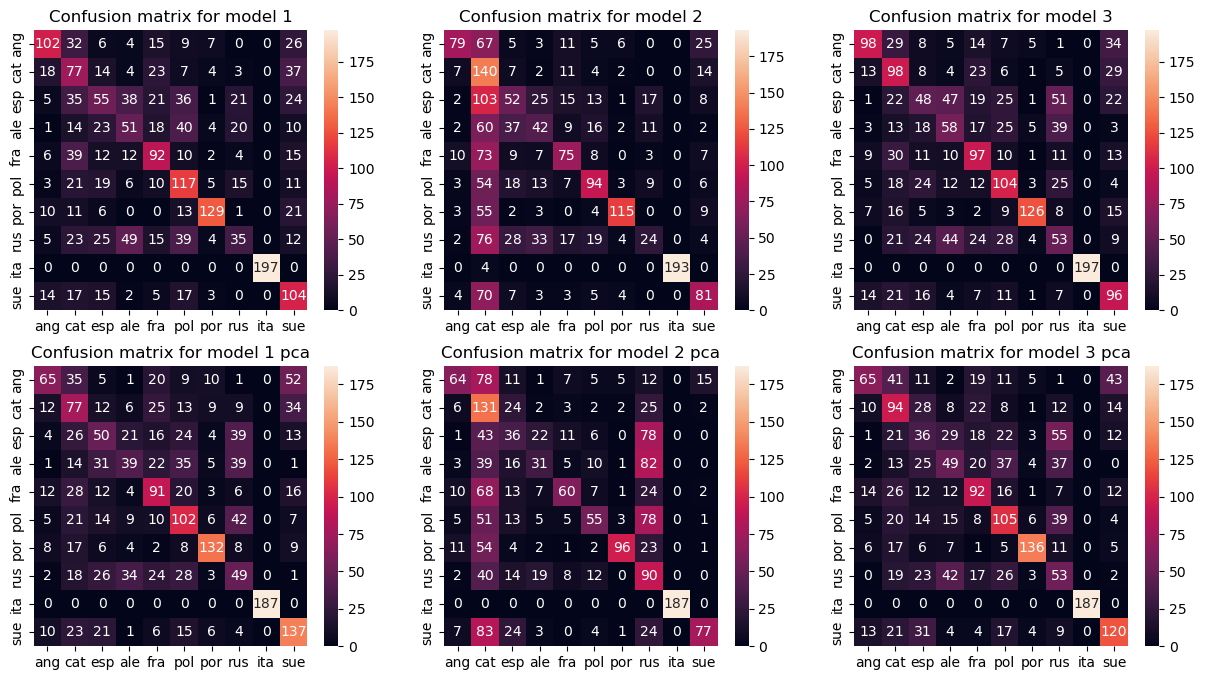

In [104]:
# Generate confusion matrices for the models and plot them as heatmaps try to make them look pretty,you can use seaborn for this
cm1 = confusion_matrix(y_test, model1.predict(X_test))
cm2 = confusion_matrix(y_test, model2.predict(X_test))
cm3 = confusion_matrix(y_test, model3.predict(X_test))

cm1_pca = confusion_matrix(y_test_pca, model1_pca.predict(X_test_pca))
cm2_pca = confusion_matrix(y_test_pca, model2_pca.predict(X_test_pca))
cm3_pca = confusion_matrix(y_test_pca, model3_pca.predict(X_test_pca))

# Plot the confusion matrices
langs =["ang", "cat", "esp", "ale", "fra", "pol", "por", "rus", "ita", "sue"]
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

sns.heatmap(cm1, annot=True, ax=ax[0][0], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm2, annot=True, ax=ax[0][1], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm3, annot=True, ax=ax[0][2], fmt='d', xticklabels=langs, yticklabels=langs)

sns.heatmap(cm1_pca, annot=True, ax=ax[1][0], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm2_pca, annot=True, ax=ax[1][1], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm3_pca, annot=True, ax=ax[1][2], fmt='d', xticklabels=langs, yticklabels=langs)

ax[0][0].set_title('Confusion matrix for model 1')
ax[0][1].set_title('Confusion matrix for model 2')
ax[0][2].set_title('Confusion matrix for model 3')

ax[1][0].set_title('Confusion matrix for model 1 pca')
ax[1][1].set_title('Confusion matrix for model 2 pca')
ax[1][2].set_title('Confusion matrix for model 3 pca')
plt.show()


Model accuracy: 50.0%
Top 3 accuracy model 0.931174


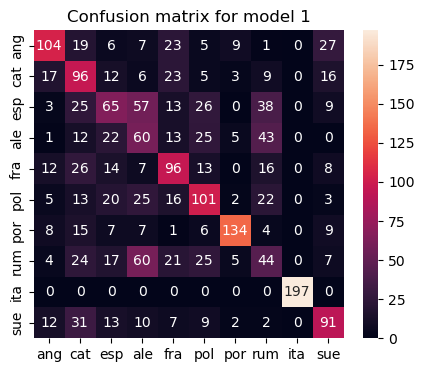

              precision    recall  f1-score   support

           0       0.63      0.52      0.57       201
           1       0.37      0.51      0.43       187
           2       0.37      0.28      0.32       236
           3       0.25      0.33      0.29       181
           4       0.45      0.50      0.47       192
           5       0.47      0.49      0.48       207
           6       0.84      0.70      0.76       191
           7       0.25      0.21      0.23       207
           8       1.00      1.00      1.00       197
           9       0.54      0.51      0.52       177

    accuracy                           0.50      1976
   macro avg       0.52      0.51      0.51      1976
weighted avg       0.51      0.50      0.50      1976



In [106]:
model_gs = svm.SVC(C=5, kernel='rbf', gamma=0.1, decision_function_shape="ovo", probability=True)
# model_gs = svm.SVC(probability=True)
model_gs.fit(X_train, y_train)
score_gs = model_gs.score(X_test, y_test)
predictions_gs = model_gs.predict_proba(X_test)
print(f'Model accuracy: {score_gs * 100}%')
print('Top 3 accuracy model %f' % top_k_accuracy_score(y_test, predictions_gs, k=3))
cm_sg = confusion_matrix(y_test, model_gs.predict(X_test))

# Plot the confusion matrices
langs =["ang", "cat", "esp", "ale", "fra", "pol", "por", "rus", "ita", "sue"]

# Plot the confusion matrices
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.heatmap(cm_sg, annot=True, ax=ax, fmt='d', xticklabels=langs, yticklabels=langs)
ax.set_title('Confusion matrix for model 1')

plt.show()
print(classification_report(y_test, model_gs.predict(X_test), zero_division=0))



In [91]:
# #Let's preform a grid search on the model1 (SVM) to find the best parameters
# # Create a pipeline
# parameters = {'C': [0.1, 1, 5, 10], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf'], "decision_function_shape": ["ovo", "ovr"]}
# svm = svm.SVC()
# svm.fit(X_train, y_train)
# grid = GridSearchCV(svm, parameters, refit=True, verbose=3)
# grid.fit(X_train, y_train)
# print(grid.best_params_)
# print(grid.best_estimator_)
